## 11. Kalman filters: analysing GPS data

This class will be an introduction to processing and analysing data from GPS recording apps such as Strava, as well as [Kalman filters](https://en.wikipedia.org/wiki/Kalman_filter). We will learn how to load, process, analyse, and visualise `.gpx` data representing a bycicle ride with the `gpxpy` Python package. Then, we will build up an intuitive understanding of Kalman filters, code them from scratch, and use the `pykalman` package for more advanced and efficient Kalman filtering of our GPS data. This Jupyter Notebook is loosely based on [this](https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/#mathybits) great blog post on Kalman filters, and [this](https://github.com/FlorianWilhelm/gps_data_with_python) Github repository for analysing `.gpx` data.

In [1]:
import gpxpy
import mplleaflet
import pykalman
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['axes.xmargin'] = 0.1
plt.rcParams['axes.ymargin'] = 0.1
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

Let's load some bicycle GPS trajectory `.gpx` file and start working with it:

In [2]:
with open('../data/Bicycle_ride_1.gpx') as fh:
    gpx_file = gpxpy.parse(fh)

In [3]:
print("File has {} track(s).".format(len(gpx_file.tracks)))

File has 1 track(s).


In [4]:
print("Track has {} segment(s).".format(len(gpx_file.tracks[0].segments)))

Track has 1 segment(s).


In [5]:
segment = gpx_file.tracks[0].segments[0]
print(segment)

GPXTrackSegment(points=[...])


In [6]:
print(type(segment.points))
segment.points[:10]

<class 'list'>


[GPXTrackPoint(41.321687, -105.574593, elevation=2199.0, time=datetime.datetime(2015, 7, 25, 11, 53, 51, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(41.321723, -105.574663, elevation=2199.5, time=datetime.datetime(2015, 7, 25, 11, 53, 53, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(41.321735, -105.574711, elevation=2199.7, time=datetime.datetime(2015, 7, 25, 11, 53, 55, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(41.321733, -105.574753, elevation=2199.9, time=datetime.datetime(2015, 7, 25, 11, 53, 58, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(41.321711, -105.574792, elevation=2200.1, time=datetime.datetime(2015, 7, 25, 11, 54, 2, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(41.321696, -105.574761, elevation=2199.9, time=datetime.datetime(2015, 7, 25, 11, 55, 46, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(41.321658, -105.574747, elevation=2199.7, time=datetime.datetime(2015, 7, 25, 11, 55, 48, tzinfo=SimpleTZ("Z"))),
 GPXTrackPoint(41.321612, -105.574741, elevation=2199.6, time=datetime.datetime(2015, 7, 25, 11, 5

Let's construct a dataframe containing the GPS points in the trajectory from the `segment.points` list.

In [7]:
coords = pd.DataFrame([{'idx': i,
                        'lat': p.latitude, 
                        'lon': p.longitude, 
                        'ele': p.elevation,
                        'time': p.time} for i, p in enumerate(segment.points)])
coords.head()

,idx,lat,lon,ele,time
0,0,41.321687,-105.574593,2199.0,2015-07-25 11:53:51+00:00
1,1,41.321723,-105.574663,2199.5,2015-07-25 11:53:53+00:00
2,2,41.321735,-105.574711,2199.7,2015-07-25 11:53:55+00:00
3,3,41.321733,-105.574753,2199.9,2015-07-25 11:53:58+00:00
4,4,41.321711,-105.574792,2200.1,2015-07-25 11:54:02+00:00


In [8]:
# clean the datetime column
coords['time'] = coords['time'].astype(str).apply(lambda x: x[:19])

# set datetime column and then as index
coords['time'] = pd.to_datetime(coords['time'], format='%Y-%m-%d %H:%M:%S')
coords.set_index('time', drop=True, inplace=True)
coords.head()

,idx,lat,lon,ele
time,,,,
2015-07-25 11:53:51,0,41.321687,-105.574593,2199.0
2015-07-25 11:53:53,1,41.321723,-105.574663,2199.5
2015-07-25 11:53:55,2,41.321735,-105.574711,2199.7
2015-07-25 11:53:58,3,41.321733,-105.574753,2199.9
2015-07-25 11:54:02,4,41.321711,-105.574792,2200.1


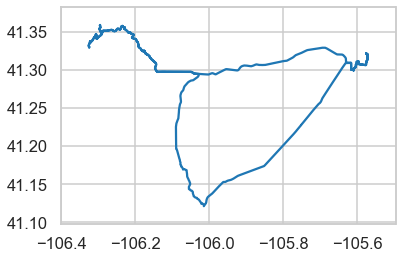

In [9]:
plt.plot(coords.lon, coords.lat)

In [10]:
# check for NaN values
print(coords.isna().values.any())

False


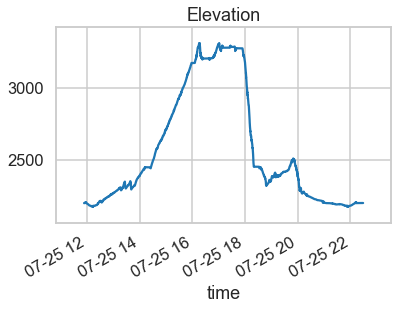

In [11]:
coords['ele'].plot(title='Elevation')
plt.show()

Now we will see a new Python module called `srtm` that reads [SRTM](https://www2.jpl.nasa.gov/srtm/) files and extracts the elevation data at the positions recorded in a `.gpx` file.

In [12]:
for point in segment.points:
    point.elevation = None
    
import srtm

elevation_data = srtm.get_data()
elevation_data.add_elevations(gpx_file, smooth=True)

coords['new_ele'] = [p.elevation for p in gpx_file.tracks[0].segments[0].points]
coords.head()

,idx,lat,lon,ele,new_ele
time,,,,,
2015-07-25 11:53:51,0,41.321687,-105.574593,2199.0,2202.000000
2015-07-25 11:53:53,1,41.321723,-105.574663,2199.5,2202.192463
2015-07-25 11:53:55,2,41.321735,-105.574711,2199.7,2202.307228
2015-07-25 11:53:58,3,41.321733,-105.574753,2199.9,2202.402698
2015-07-25 11:54:02,4,41.321711,-105.574792,2200.1,2202.513349


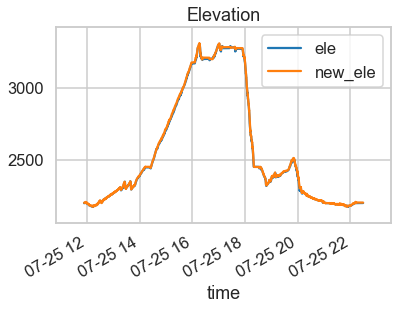

In [13]:
coords[['ele','new_ele']].plot(title='Elevation')
plt.show()

### Speeds

Let's work a bit with time and speed of our bicycle trip:

In [14]:
start_time, end_time = segment.get_time_bounds()
duration = end_time - start_time

average_speed = segment.length_3d() / duration.seconds * 3.6
print("Average speed is {:.2f} km/h".format(average_speed))

Average speed is 18.08 km/h


#### Speed at specific points

In [15]:
# the first and last points should have a speed of 0, right?
segment.points[0].speed = 0.0
segment.points[-1].speed = 0.0
gpx_file.add_missing_speeds()

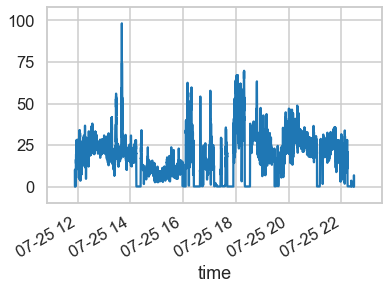

In [16]:
coords['speed'] = [p.speed for p in segment.points]
coords['speed'] *= 3.6
coords['speed'].plot()
plt.show()

Let's check maximum speed:

In [17]:
coords['speed'].max()

98.27371711623378

Hmm... that looks a bit too fast for a bicycle... What about uphill and downhill distances?

In [18]:
segment.get_uphill_downhill()

UphillDownhill(uphill=2312.9778707266287, downhill=2311.9778707266287)

What?! That's almost double of what we would intuitively expect to climb up and down! We will see how to address this issue with Kalman filters later in the Notebook.

### Interactive plotting

In [19]:
# let's print a list of coordinate pairs of our trajectory
list(zip(coords.lat, coords.lon))[:10]

[(41.321687, -105.574593),
 (41.321723, -105.574663),
 (41.321735, -105.574711),
 (41.321733, -105.574753),
 (41.321711, -105.574792),
 (41.321696, -105.574761),
 (41.321658, -105.574747),
 (41.321612, -105.574741),
 (41.321562, -105.574743),
 (41.321532, -105.574743)]

In [20]:
import folium 

def plot_GPX(df, zoom):
    '''
    overlay a gpx route on top of an OSM map using Folium
    '''
    # get geometric center of the trajectory
    points = list(zip(coords.lat, coords.lon))
    latitude = sum(p[0] for p in points)/len(points)
    longitude = sum(p[1] for p in points)/len(points)
    
    # initialise a folium Map object and start plotting
    myMap = folium.Map(location=[latitude,longitude],zoom_start=zoom)
    folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(myMap)
    folium.TileLayer('CartoDB positron').add_to(myMap)
    
    return (myMap)

In [21]:
plot_GPX(coords, 10)

### So what is a Kalman filter?

In statistics and control theory, Kalman filtering, also known as linear quadratic estimation (LQE), is an algorithm that uses a series of measurements observed over time, containing statistical (Gaussian) noise and other inaccuracies, and produces estimates of unknown variables describing the state of the object being measured, such as position, speed, acceleration, etc.

Kalman filters are typically used in spatio-temporal processes where there is **uncertain information** about the dynamic process, and allow an **educated guess** about the future behaviour of the process. Kalman filters are very good at figuring out the *actual* spatio-temporal behaviour, even if process noise or measurement errors show us an inaccurate, noisy picture of the process. Kalman filters take advantage of correlations between phenomena that wouldn't seem so trivial to exploit at first sight! To see this, let's build up an intuitive understanding of what and how a Kalman filter actually does:

### Kalman filter intuition

Let's stay we are tracking an object in space whose state is described by position and velocity:

$$
\vec{x}=\left[\begin{array}{l}
p \\
v
\end{array}\right]
$$

Since we are observing only the _measured_ position and velocity of the object, the _actual_ position and velocity are not known; there is a large space of possible combinations of position and velocity that might be true, but some of them are more likely than others:

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

![title](images/kalman1.png)
<font color='grey'>Source: bzarg.com</font> 
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

In Kalman filters, all process states are assumed to be random and Gaussian distributed. The position and velocity distributions have means $\mu_p$ and $\mu_v$, and variances $\sigma_p$ and $\sigma_v$, respectively:

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

![title](images/kalman2.png)
<font color='grey'>Source: bzarg.com</font>
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

In the schematic picture above, the distributions of position and velocity have **no correlation**, meaning that knowledge about one tells us nothing about the other. In a typical scenario, however, position and velocity will tend to be correlated, such as when estimating a new position based on an old one: if the object is moving fast, it will cover a longer distance before the next measurement, and vice versa.

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

![title](images/kalman3.png)
<font color='grey'>Source: bzarg.com</font>
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

This correlative relationship between our state variables is very important to keep track of, **because it offers more information**: measurement of one state variable tells us something about what the others might be. And that's what Kalman filters try to do: extractng and encoding as much information from inaccurate and uncertain measurements as possible.

We know from linear algebra that correlations in a multidimensional space are captured by covariance matrices.

### Matrix algebra

Our knowledge about the object state is represented as a Gaussian blob, so we need two pieces of information at time $k$: Our best estimate $\hat{\mathbf{x}}_{k}$ (the mean, elsewhere named $\mu$), and its covariance matrix $\mathbf{P}_{k}$.

$$
\begin{equation*}
\begin{aligned}
\hat{\mathbf{x}}_{k} &=\left[\begin{array}{c}
\text { position } \\
\text { velocity }
\end{array}\right] \\
\mathbf{P}_{k} &=\left[\begin{array}{cc}
\Sigma_{p p} & \Sigma_{p v} \\
\Sigma_{v p} & \Sigma_{v v}
\end{array}\right]
\end{aligned}
\label{eq:1} \tag{1}
\end{equation*}
$$


Next, we need a way to take the **current state** (at time $k-1$) and **predict the next state** at time $k$. Note that we don't actually know which state is the _real_ one, so instead of taking as input one particular state and making a prediction regarding the next state for it, our prediction function will take _all states_ and give a new distribution:

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

![title](images/kalman4.jpg)
<font color='grey'>Source: bzarg.com</font>
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

Let's represent this prediction step with a matrix operation and call it $\mathbf{F}_{k}$:

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

![title](images/kalman5.jpg)
<font color='grey'>Source: bzarg.com</font>
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

The matrix $\mathbf{F}_{k}$ takes _every point_ in the distribution of our original estimate of states, and moves it to a new predicted location, which is where the object would move if that original estimate was the right one.

Let's write this down. How can we formulate the relationship between the new and old object states?

$$
\begin{array}{rlr}
p_{k} & =p_{k-1}+\Delta t v_{k-1} \\
v_{k} & = &v_{k-1}
\end{array}
$$

Or, in matrix form:

$$
\begin{equation*}
\begin{aligned}
\hat{\mathbf{x}}_{k} &=\left[\begin{array}{cc}
1 & \Delta t \\
0 & 1
\end{array}\right] \hat{\mathbf{x}}_{k-1} \\
& =\mathbf{F}_{k} \hat{\mathbf{x}}_{k-1}  
\end{aligned}
\label{eq:2} \tag{2}
\end{equation*}
$$

We now have a **prediction matrix** which gives us our next state, but we still don’t know how to update the covariance matrix. The question is: what happens to the covariance matrix $\Sigma$ if we multiply all points of the joint distribution by a matrix $\mathbf{A}$? Well, it's a trivial linear algebra exercise:

$$
\begin{equation*}
\begin{aligned}
\operatorname{Cov}(x) &=\Sigma \\
\operatorname{Cov}(\mathbf{A} x) &=\mathbf{A} \Sigma \mathbf{A}^{T}
\end{aligned}
\label{eq:3} \tag{3}
\end{equation*}
$$

Combining (3) with (2):

$$
\begin{equation*}
\begin{aligned}
\hat{\mathbf{x}}_{k} &=\mathbf{F}_{k} \hat{\mathbf{x}}_{k-1} \\
\mathbf{P}_{k} &=\mathbf{F}_{\mathbf{k}} \mathbf{P}_{k-1} \mathbf{F}_{k}^{T}
\end{aligned}
\label{eq:4} \tag{4}
\end{equation*}
$$

### Exogenous factors 

So far, we have modelled uncertainty related to the object state itself. However, there might also be external influence, unrelated to the object state and the uncertainty associated with measuring it. For example, the driver of a car moving at a constant speed may suddenly choose to press the throttle and accelerate the car. This additional information about external factors can be put into a vector called $\overrightarrow{\mathbf{u}_{k}}$, manipulate it somehow, and add it to our prediction as a correction.

Let's say we know the expected acceleration $a$ due to the throttle setting or control commands. Basic kinematics tells us:

$$
\begin{aligned}
p_{k} &=p_{k-1}+\Delta t v_{k-1}+\frac{1}{2} a \Delta t^{2} \\
v_{k} &=\quad v_{k-1}+a \Delta t
\end{aligned}
$$

or, in matrix form:

$$
\begin{equation*}
\begin{aligned}
\hat{\mathbf{x}}_{k} &=\mathbf{F}_{k} \hat{\mathbf{x}}_{k-1}+\left[\begin{array}{c}
\frac{\Delta t^{2}}{2} \\
\Delta t
\end{array}\right] a \\
&=\mathbf{F}_{k} \hat{\mathbf{x}}_{k-1}+\mathbf{B}_{k} \overrightarrow{\mathbf{u}_{k}}
\end{aligned}
\label{eq:5} \tag{5}
\end{equation*}
$$

$\mathbf{B}_{k}$ is called the control matrix and $\overrightarrow{\mathbf{u}_{k}}$ the control vector.

Finally, there is an additional **external** uncertainty that we need to add to our model.

### External uncertainty

So far, we have considered the process state evolving based on its _internal_ properties as well as external forces that we explicitly know about. But what happens if some _unknown_ external force happens to affect the process state? For example, the car could reach very poor road conditions that would force it to slow down. We can't keep track of these kind of uncertainty, and if any of that happens, our prediction could be off because we didn't account for those extra forces.

We can model the uncertainty due to the external "world" (i.e. things we don't and can't keep track of) by adding some new uncertainty after every prediction step:

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

![title](images/kalman6.jpg)
<font color='grey'>Source: bzarg.com</font>
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

Every process state in our original estimate could have moved to a _range_ of possible states. We can think of it as each point in $\hat{\mathbf{x}}_{k-1}$ is moved to somewhere inside a 2D Gaussian with covariance $\color{green}{\mathbf{Q}_{k}}$. Another way to say this is that we are treating the untracked external forces as noise with covariance $\color{green}{\mathbf{Q}_{k}}$.
 
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

![title](images/kalman7.jpg)
<font color='grey'>Source: bzarg.com</font>
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$


This results in a new 2D Gaussian with a different covariance (but the same mean!):

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

![title](images/kalman8.jpg)
<font color='grey'>Source: bzarg.com</font>
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$
 
 
 $$
\begin{equation*}
\begin{aligned}
\hat{\mathbf{x}}_{k} &=\mathbf{F}_{k} \hat{\mathbf{x}}_{k-1}+\mathbf{B}_{k} \overrightarrow{\mathbf{u}_{k}} \\
\mathbf{P}_{k} &=\mathbf{F}_{\mathbf{k}} \mathbf{P}_{k-1} \mathbf{F}_{k}^{T}+\mathbf{Q}_{k}
\end{aligned}
\label{eq:6} \tag{6}
\end{equation*}
$$

What we see is simply that our **new best guess** is a prediction made from our **previous best guess**, plus a correction for **known external influences**. On top of that, the **new uncertainty** is predicted from the **old uncertainty**, plus some **additional uncertainty** from the environment.

So, we now have a rough estimate of where our system might be, represented by $\hat{\mathbf{x}}_{k}$ and $\mathbf{P}_{k}$.

### Including sensor measurements

Whatever the process we are modelling, what we actually see is **indirect** information about the state of the system through sensors that produce somewhat inaccurate readings.

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

![title](images/kalman9.jpg)
<font color='grey'>Source: bzarg.com</font>
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

Since  the units and scale of the sensor readings are not necessarily the same as the units and scale of the state we're keeping track of, we will model the sensor readings as a matrix operation, $\mathbf{H}_{k}$.

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

![title](images/kalman10.jpg)
<font color='grey'>Source: bzarg.com</font>
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

The distribution resulting from this matrix operation is similar to equation (4) we saw above.

$$
\begin{equation*}
\begin{aligned}
\vec{\mu}_{\text {expected }} &=\mathbf{H}_{k} \hat{\mathbf{x}}_{k} \\
\boldsymbol{\Sigma}_{\text {expected }} &=\mathbf{H}_{k} \mathbf{P}_{k} \mathbf{H}_{k}^{T}
\end{aligned}
\label{eq:7} \tag{7}
\end{equation*}
$$

Now, since we have additional uncertainty due to sensor measurement error, every state in our original guess might result in a _range_ of sensor readings.

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

![title](images/kalman11.jpg)
<font color='grey'>Source: bzarg.com</font>
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

So, when we observe a sensor reading, we must keep in mind that the _real_ state that might have produced the sensor reading we are observing might be somewhere else within that distribution, with the most likely state being the mean of the distribution.

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

![title](images/kalman12.jpg)
<font color='grey'>Source: bzarg.com</font>
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$


Let's call the covariance of this uncertainty (i.e. of the sensor noise) $\mathbf{R}_{k}$. The distribution has a mean equal to the reading we observed, that we shall call $\overrightarrow{\mathbf{z}_{k}}$.

So now we have two Gaussian blobs: One surrounding the mean of our transformed prediction, and one surrounding the actual sensor reading we got.

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

![title](images/kalman13.jpg)
<font color='grey'>Source: bzarg.com</font>
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

So, we should try to combine our guess about the readings we would see based on the **predicted state ($\color{violet}{\text{pink}}$)** with a different guess based on our **sensor readings ($\color{green}{\text{green}}$)** that we actually observed.

So what's our current most likely state? For any possible reading $(z1,z2)$, we have two associated probabilities: 

1. the probability that our sensor reading $\overrightarrow{\mathbf{z}_{k}}$ is a (mis-)measurement of $(z1,z2)$, and
2. the probability that our previous estimate thinks $(z1,z2)$ is the reading we should see.

From probability theory, we know that whenever we have two probabilities and we want to know the chance that both are true, we simply multiply them together. Therefore, we take the two Gaussian blobs and multiply them:

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

![title](images/kalman14.png)
<font color='grey'>Source: bzarg.com</font>
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

As you see in the image above, this region is the **overlap** between the two Gaussians, the region where both blobs have most of their probability mass. This overlap represents a lot more precise estimate than either of our previous estimates. The mean of this distribution is the configuration for which both estimates are most likely, and is therefore the best guess of the true configuration given all the information we have. It turns out, when you multiply two Gaussian distributions with different means and covariances, you obtain a _new_ Gaussian distribution with its **own** mean and covariance matrix!

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

![title](images/kalman15.png)
<font color='grey'>Source: bzarg.com</font>
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

From multivariate statistics we know that the formula for obtaining the mean and covariance of the _new_ Gaussian blob we get by multiplying our two Gaussians, is:

$$
\begin{equation*}
\begin{aligned}
\vec{\mu}^{\prime} &=\vec{\mu}_{0}+\mathbf{K}\left(\overrightarrow{\mu_{1}}-\overrightarrow{\mu_{0}}\right) \\
\Sigma^{\prime} &=\Sigma_{0}-\mathbf{K} \Sigma_{0}
\end{aligned}
\label{eq:8} \tag{8}
\end{equation*}
$$

where $\mathbf{K}=\Sigma_{0}\left(\Sigma_{0}+\Sigma_{1}\right)^{-1}$ is a matrix called the **Kalman gain**.

### Putting everything together

As a reminder, we now have **two** distributions of estimates:

1. The predicted state with $\left(\mu_{0}, \Sigma_{0}\right)=\left(\mathbf{H}_{k} \hat{\mathbf{x}}_{k}, \mathbf{H}_{k} \mathbf{P}_{k} \mathbf{H}_{k}^{T}\right)$, and

2. the observed sensor measurement with $\left(\mu_{1}, \Sigma_{1}\right)=\left(\overrightarrow{\mathbf{z}_{k}}, \mathbf{R}_{k}\right)$

Now, we can simply plug them in equation (8) and find their overlap:

$$
\begin{equation*}
\begin{aligned}
\mathbf{H}_{k} \hat{\mathbf{x}}_{k}^{\prime} &=\mathbf{H}_{k} \hat{\mathbf{x}}_{k} +\mathbf{K}\left(\overrightarrow{\mathbf{z}_{k}}-\mathbf{H}_{k} \hat{\mathbf{x}}_{k}\right) \\
\mathbf{H}_{k} \mathbf{P}_{k}^{\prime} \mathbf{H}_{k}^{T} &=\mathbf{H}_{k} \mathbf{P}_{k} \mathbf{H}_{k}^{T} -\mathbf{K H}_{k} \mathbf{P}_{k} \mathbf{H}_{k}^{T}
\end{aligned}
\label{eq:9} \tag{9}
\end{equation*}
$$

where the Kalman gain is:

$$
\begin{equation*}
\mathbf{K}=\mathbf{H}_{k} \mathbf{P}_{k} \mathbf{H}_{k}^{T}\left(\mathbf{H}_{k} \mathbf{P}_{k} \mathbf{H}_{k}^{T}+\mathbf{R}_{k}\right)^{-1}
\label{eq:10} \tag{10}
\end{equation*}
$$

Doing some simple algebra (getting rid of $\mathbf{H}_{k}$ at the beginning and the end of the above equations), we obtain:

$$
\begin{equation*}
\begin{aligned}
\hat{\mathbf{x}}_{k}^{\prime} &=\hat{\mathbf{x}}_{k}+\mathbf{K}^{\prime}\left(\overrightarrow{\mathbf{z}_{k}}-\mathbf{H}_{k} \hat{\mathbf{x}}_{k}\right) \\
\mathbf{P}_{k}^{\prime} &=\mathbf{P}_{k}-\mathbf{K}^{\prime} \mathbf{H}_{k} \mathbf{P}_{k}
\end{aligned}
\label{eq:11} \tag{11}
\end{equation*}
$$

$$
\begin{equation*}
\mathbf{K}^{\prime}=\mathbf{P}_{k} \mathbf{H}_{k}^{T}\left(\mathbf{H}_{k} \mathbf{P}_{k} \mathbf{H}_{k}^{T}+\mathbf{R}_{k}\right)^{-1}
\label{eq:12} \tag{12}
\end{equation*}
$$

which are the equations for the **update step** of the Kalman filter.

And that concludes our overview of the Kalman filter! $\hat{\mathbf{x}}_{k}^{\prime}$ is our new best estimate for the location and velocity of the object we are tracking, and we can go ahead and feed it (along with $\mathbf{P}_{k}^{\prime}$) back into another round of **predict and update** loop.

Now, let's apply all the theory we just learned to our bicycle GPS trajectory by coding a Kalman filter from scratch!

In [22]:
simplified_coords = coords[["lon", "lat"]].values
simplified_coords

array([[-105.574593,   41.321687],
       [-105.574663,   41.321723],
       [-105.574711,   41.321735],
       ...,
       [-105.574816,   41.321795],
       [-105.574809,   41.321755],
       [-105.574804,   41.321728]])

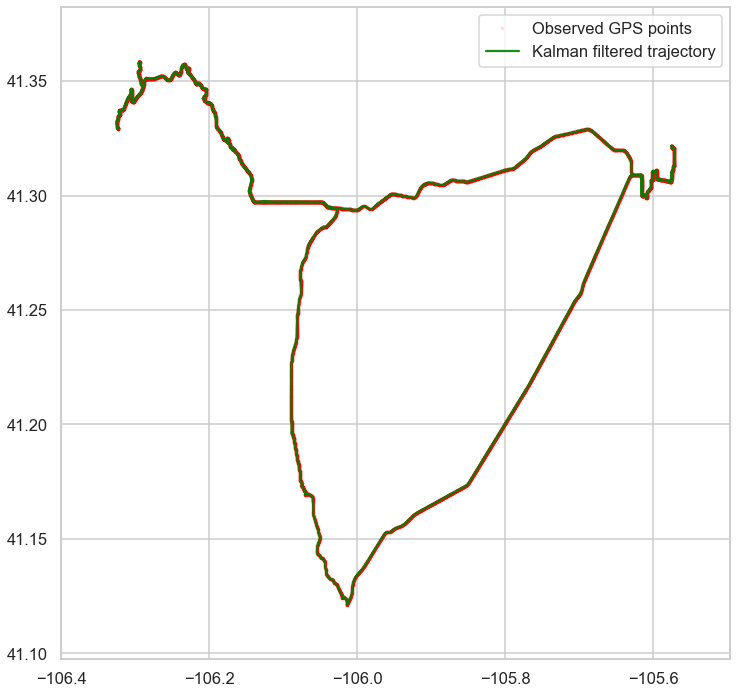

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def kalman_xy(x, P, measurement, R,
              motion = np.matrix('0. 0. 0. 0.').T,
              Q = np.matrix(np.eye(4))):
    """
    Parameters:    
    x: initial state 4-tuple of location and velocity: (x0, x1, x0_dot, x1_dot)
    P: initial uncertainty convariance matrix
    measurement: observed position
    R: measurement noise 
    motion: external motion added to state vector x
    Q: motion noise (same shape as P)
    """
    return kalman(x, P, measurement, R, motion, Q,
                  F = np.matrix('''
                      1. 0. 1. 0.;
                      0. 1. 0. 1.;
                      0. 0. 1. 0.;
                      0. 0. 0. 1.
                      '''),
                  H = np.matrix('''
                      1. 0. 0. 0.;
                      0. 1. 0. 0.'''))

def kalman(x, P, measurement, R, motion, Q, F, H):
    '''
    Parameters:
    x: initial state
    P: initial uncertainty convariance matrix
    measurement: observed position (same shape as H*x)
    R: measurement noise (same shape as H)
    motion: external motion added to state vector x
    Q: motion noise (same shape as P)
    F: next state function: x_prime = F*x
    H: measurement function: position = H*x

    Return: the updated and predicted new values for (x, P)

    See also http://en.wikipedia.org/wiki/Kalman_filter

    This version of kalman can be applied to many different situations by
    appropriately defining F and H 
    '''
    # UPDATE x, P based on measurement m    
    # distance between measured and current position-belief
    y = np.matrix(measurement).T - H * x
    S = H * P * H.T + R  # residual convariance
    K = P * H.T * S.I    # Kalman gain
    x = x + K*y
    I = np.matrix(np.eye(F.shape[0])) # identity matrix
    P = (I - K*H)*P

    # PREDICT x, P based on motion
    x = F*x + motion
    P = F*P*F.T + Q

    return x, P

def demo_kalman_xy():
    x = np.matrix('0. 0. 0. 0.').T 
    P = np.matrix(np.eye(4))*100 # initial uncertainty

    N = len(simplified_coords)

    observed_x = simplified_coords[:,0]
    observed_y = simplified_coords[:,1]
    
    # plot original points along with estimates
    fig, ax = plt.subplots(figsize=(12,12))
    ax.plot(observed_x, observed_y, 'ro', alpha=0.1, markersize=2.5, label='Observed GPS points')
    result = []
    R = 0.001**2
    for meas in zip(observed_x, observed_y):
        x, P = kalman_xy(x, P, meas, R)
        result.append((x[:2]).tolist())
    kalman_x, kalman_y = zip(*result)
    plt.plot(kalman_x, kalman_y, 'g-', alpha =0.9, label='Kalman filtered trajectory')
    plt.legend()
    plt.show()

demo_kalman_xy()

Let's take a look at the time sampling.

In [24]:
coords.head()

,idx,lat,lon,ele,new_ele,speed
time,,,,,,
2015-07-25 11:53:51,0,41.321687,-105.574593,2199.0,2202.000000,0.000000
2015-07-25 11:53:53,1,41.321723,-105.574663,2199.5,2202.192463,10.193759
2015-07-25 11:53:55,2,41.321735,-105.574711,2199.7,2202.307228,5.580449
2015-07-25 11:53:58,3,41.321733,-105.574753,2199.9,2202.402698,3.908040
2015-07-25 11:54:02,4,41.321711,-105.574792,2200.1,2202.513349,0.238782


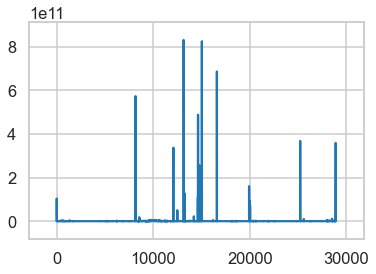

In [25]:
plt.plot(np.diff(coords.index))

Let's resample with 1 sec intevals and fill in with NaN:

In [26]:
coords = coords.resample('1S').asfreq()
coords.loc[coords.ele.isnull()].head()

,idx,lat,lon,ele,new_ele,speed
time,,,,,,
2015-07-25 11:53:52,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-25 11:53:54,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-25 11:53:56,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-25 11:53:57,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-25 11:53:59,NaN,NaN,NaN,NaN,NaN,NaN


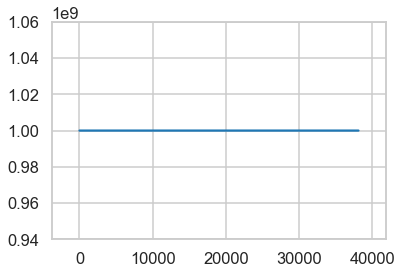

In [27]:
plt.plot(np.diff(coords.index))
plt.show()

Finally, we convert it to a numpy array and mask NaNs:

In [28]:
measurements = np.ma.masked_invalid(coords[['lon', 'lat', 'ele']].values)
measurements[:10]

masked_array(
  data=[[-105.574593, 41.321687, 2199.0],
        [--, --, --],
        [-105.574663, 41.321723, 2199.5],
        [--, --, --],
        [-105.574711, 41.321735, 2199.7],
        [--, --, --],
        [--, --, --],
        [-105.574753, 41.321733, 2199.9],
        [--, --, --],
        [--, --, --]],
  mask=[[False, False, False],
        [ True,  True,  True],
        [False, False, False],
        [ True,  True,  True],
        [False, False, False],
        [ True,  True,  True],
        [ True,  True,  True],
        [False, False, False],
        [ True,  True,  True],
        [ True,  True,  True]],
  fill_value=1e+20)

### Pykalman implementation

Now, let's return to the problem with up- and down-hill distances, and solve it with the `Pykalman` implementation of the Kalman filter.

Given position $\mathbf{x}_{k}=(x_{k},y_{k},z_{k})$ and velocity $\mathbf{v}_{k}=(\alpha_{k},\beta_{k},\gamma_{k})$ our model state equation in matrix form is

$$ \begin{pmatrix} x_{k+1} \\ y_{k+1} \\ z_{k+1} \\ \alpha_{k+1} \\ \beta_{k+1} \\ \gamma_{k+1} \\ \end{pmatrix}= \begin{pmatrix} 1 & 0 & 0 & dt & 0 & 0 \\ 0 & 1 & 0 & 0 & dt & 0 \\ 0 & 0 & 1 & 0 & 0 & dt \\ 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 \\ \end{pmatrix} \cdot \begin{pmatrix} x_{k} \\ y_{k} \\ z_{k} \\ \alpha_{k} \\ \beta_{k} \\ \gamma_{k} \\ \end{pmatrix}+ \begin{pmatrix} \epsilon^1_{k} \\ \epsilon^2_{k} \\ \epsilon^3_{k} \\ \epsilon^4_{k} \\ \epsilon^5_{k} \\ \epsilon^6_{k} \\ \end{pmatrix}. $$ For the sampling rate in our date $dt=1$.

In [29]:
# let's set it up

from pykalman import KalmanFilter

F = np.array([[1, 0, 0, 1, 0, 0],
              [0, 1, 0, 0, 1, 0],
              [0, 0, 1, 0, 0, 1],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])

H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])

R = np.diag([1e-4, 1e-4, 100])**2

initial_state_mean = np.hstack([measurements[0, :], 3*[0.]])
# works initial_state_covariance = np.diag([1e-3, 1e-3, 100, 1e-4, 1e-4, 1e-4])**2
initial_state_covariance = np.diag([1e-4, 1e-4, 50, 1e-6, 1e-6, 1e-6])**2

In [30]:
kf = KalmanFilter(transition_matrices=F, 
                  observation_matrices=H, 
                  observation_covariance=R,
                  initial_state_mean=initial_state_mean,
                  initial_state_covariance=initial_state_covariance,
                  em_vars=['transition_covariance'])

In [31]:
# The expectation maximisation algorithm for computing the predict & update steps can 
# take several hours!
#kf = kf.em(measurements, n_iter=1000)
# or just run this instead of the one above (it is the same result)
Q = np.array([[  3.17720723e-09,  -1.56389148e-09,  -2.41793770e-07,
                 2.29258935e-09,  -3.17260647e-09,  -2.89201471e-07],
              [  1.56687815e-09,   3.16555076e-09,   1.19734906e-07,
                 3.17314157e-09,   2.27469595e-09,  -2.11189940e-08],
              [ -5.13624053e-08,   2.60171362e-07,   4.62632068e-01,
                 1.00082746e-07,   2.81568920e-07,   6.99461902e-05],
              [  2.98805710e-09,  -8.62315114e-10,  -1.90678253e-07,
                 5.58468140e-09,  -5.46272629e-09,  -5.75557899e-07],
              [  8.66285671e-10,   2.97046913e-09,   1.54584155e-07,
                 5.46269262e-09,   5.55161528e-09,   5.67122163e-08],
              [ -9.24540217e-08,   2.09822077e-07,   7.65126136e-05,
                 4.58344911e-08,   5.74790902e-07,   3.89895992e-04]])
Q = 0.5*(Q + Q.T) # assure symmetry
kf.transition_covariance = Q

In [32]:
state_means, state_vars = kf.smooth(measurements)

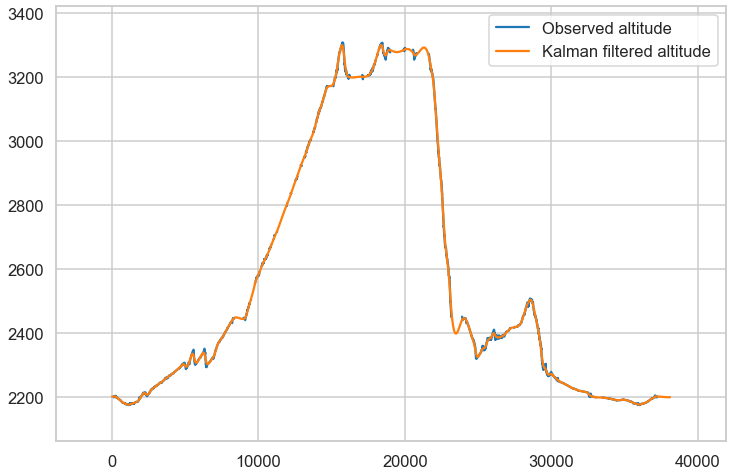

In [33]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(measurements[:,2], label="Observed altitude")
ax.plot(state_means[:,2], label="Kalman filtered altitude")
plt.legend()
plt.show()

In [34]:
coords.head()

,idx,lat,lon,ele,new_ele,speed
time,,,,,,
2015-07-25 11:53:51,0.0,41.321687,-105.574593,2199.0,2202.000000,0.000000
2015-07-25 11:53:52,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-25 11:53:53,1.0,41.321723,-105.574663,2199.5,2202.192463,10.193759
2015-07-25 11:53:54,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-25 11:53:55,2.0,41.321735,-105.574711,2199.7,2202.307228,5.580449


Let's write the smoothed data back into our dataframe and GPX file.

In [35]:
coords.loc[:, ['lon', 'lat', 'ele']] = state_means[:, :3]
orig_coords = coords.loc[~coords['idx'].isnull()].set_index('idx')
orig_coords.head()

,lat,lon,ele,new_ele,speed
idx,,,,,
0.0,41.321694,-105.574604,2202.060972,2202.000000,0.000000
1.0,41.321710,-105.574648,2202.065407,2202.192463,10.193759
2.0,41.321732,-105.574702,2202.071208,2202.307228,5.580449
3.0,41.321734,-105.574754,2202.077662,2202.402698,3.908040
4.0,41.321712,-105.574793,2202.084703,2202.513349,0.238782


In [36]:
for i, p in enumerate(segment.points):
    p.speed = None
    p.elevation = orig_coords.at[float(i),'ele']
    p.longitude = orig_coords.at[float(i),'lon']
    p.latitude = orig_coords.at[float(i),'lat']

In [37]:
segment.get_uphill_downhill()

UphillDownhill(uphill=1562.0129207574769, downhill=1564.029134354667)

This looks much better!

### Homework assignment

* Download and install [Strava](https://www.strava.com/) on your smartphone and create an account. 
* Take a bicycle ride, a car trip, or a simple run with Strava recording your activity.
* [Download](https://support.strava.com/hc/en-us/articles/216918437-Exporting-your-Data-and-Bulk-Export) your activity data as a `.gpx` file.
* Analyse your **own** GPS trajectory using the skills you acquired in this class!

Complete the homework assignment in a clean Jupyter Notebook, name the notebook **< Name > < Surname > Class 11 Homework** and upload it to Moodle.